This notebook is based on https://keras.io/examples/audio/speaker_recognition_using_cnn/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

In [ ]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, Audio

# Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download
# and save it to the 'Downloads' folder in your HOME directory
DATASET_ROOT = "/content/drive/MyDrive/AI_Project/archive/16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 64
EPOCHS = 50


## Data preparation



In [ ]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

## Noise preparation


In [ ]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


Resample all noise samples to 16000 Hz

In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


## Dataset generation

In [ ]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

Our class names: ['Benjamin_Netanyau', 'Nelson_Mandela', 'Julia_Gillard', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Fatima_Azim', 'Safiya_Mehmood', 'Husun_Bano']
Processing speaker Benjamin_Netanyau
Processing speaker Nelson_Mandela
Processing speaker Julia_Gillard
Processing speaker Jens_Stoltenberg
Processing speaker Magaret_Tarcher
Processing speaker Fatima_Azim
Processing speaker Safiya_Mehmood
Processing speaker Husun_Bano
Found 12002 files belonging to 8 classes.
Using 10802 files for training.
Using 1200 files for validation.


## Model Definition

In [ ]:
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.models import Sequential
 
def build_model():
    input_shape = (None, 8000, 1)
    
    model = Sequential()
    # model.add(LSTM(64, batch_input_shape=(None, 8000, 1), activation='tanh', return_sequences=True))
    # model.add(LSTM(75, activation='tanh', return_sequences=True, dropout=0.2))
    # model.add(LSTM(64, activation='tanh'))
    # model.add(Dense(8, activation='softmax'))
    model.add(LSTM(256, return_sequences=True, batch_input_shape=(None, 8000, 1), dropout=0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))
    return model
 

model = build_model()
model.summary()
 
#ADJUSTING LEARNING RATE
optimizer = keras.optimizers.Adam(lr=0.001)
 
 
# Compile the model using Adam's default learning rate
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
 
# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"
 
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 8000, 256)         264192    
_________________________________________________________________
lstm_24 (LSTM)               (None, 8000, 128)         197120    
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               131072128 
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 1032      
Total params: 131,534,472
Trainable params: 131,534,472
Non-trainable params: 0
_______________________________________

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 8000, 1), (None,)), types: (tf.float32, tf.int32)>

## Training

Epoch 1/50
169/169 [==============================] - 199s 1s/step - loss: 9.4691 - accuracy: 0.1870 - val_loss: 1.8011 - val_accuracy: 0.2875
Epoch 2/50
169/169 [==============================] - 197s 1s/step - loss: 1.8140 - accuracy: 0.2594 - val_loss: 1.7530 - val_accuracy: 0.3125
Epoch 3/50
169/169 [==============================] - 199s 1s/step - loss: 1.6506 - accuracy: 0.3112 - val_loss: 1.9579 - val_accuracy: 0.2562
Epoch 4/50
169/169 [==============================] - 199s 1s/step - loss: 1.4671 - accuracy: 0.3812 - val_loss: 1.7518 - val_accuracy: 0.2875
Epoch 5/50
169/169 [==============================] - 199s 1s/step - loss: 1.4358 - accuracy: 0.3877 - val_loss: 1.5396 - val_accuracy: 0.3313
Epoch 6/50
169/169 [==============================] - 200s 1s/step - loss: 1.4283 - accuracy: 0.4091 - val_loss: 1.3205 - val_accuracy: 0.4437
Epoch 7/50
169/169 [==============================] - 199s 1s/step - loss: 1.3382 - accuracy: 0.4413 - val_loss: 1.3077 - val_accuracy: 0.4875

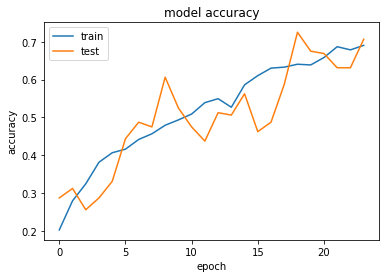

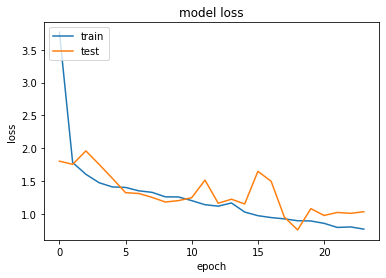

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    #steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=valid_ds,
    validation_steps=5,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')    
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show() 

## Evaluation

In [ ]:
print(model.evaluate(train_ds))

169/169 [==============================] - 134s 783ms/step - loss: 0.6303 - accuracy: 0.8164
[0.6302580237388611, 0.8164228796958923]


In [ ]:
print(model.evaluate(valid_ds))

38/38 [==============================] - 18s 444ms/step - loss: 0.7644 - accuracy: 0.7533
[0.7644160389900208, 0.753333330154419]


###Final Accuracy after Hyperparameter Tuning: 75%

## Demonstration


In [ ]:
SAMPLES_TO_DISPLAY = 20

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))